<a href="https://colab.research.google.com/github/Ramyavijaykumar/ANN_HeartSoundClassification_LSTMRNN/blob/main/HEARTBEATHARMONICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import lazy_loader as lazy
import soundfile as sf
import audioread

from __future__ import annotations
from numba import jit, stencil, guvectorize

from typing import Any, BinaryIO, Callable, Generator, Optional, Tuple, Union, List
from numpy.typing import DTypeLike, ArrayLike
import scipy.signal
import soxr


Populating the interactive namespace from numpy and matplotlib


In [ ]:
pip install tensorflow==2.14.0

In [ ]:
# gather software versions
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.14.0
keras version:  2.14.0


In [ ]:
# parent folder of sound files
INPUT_DIR="/content/HeartBeatHarmonics/Input"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12

In [ ]:
!pwd
!ls -all "/content/HeartBeatHarmonics/Input"

/content
total 92
drwxr-xr-x 5 root root  4096 Oct 31 13:28 .
drwxr-xr-x 5 root root  4096 Oct 31 13:28 ..
drwxr-xr-x 2 root root  4096 Oct 31 13:14 .ipynb_checkpoints
drwxr-xr-x 2 root root  4096 Oct 31 13:17 set_a
-rw-r--r-- 1 root root  7031 Oct 31 13:14 set_a.csv
-rw-r--r-- 1 root root 17115 Oct 31 13:14 set_a_timing.csv
drwxr-xr-x 2 root root  4096 Oct 31 13:20 set_b
-rw-r--r-- 1 root root 42145 Oct 31 13:14 set_b.csv


In [ ]:
set_a=pd.read_csv(INPUT_DIR+"/set_a.csv")
set_a.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [ ]:
set_a_timing=pd.read_csv(INPUT_DIR+"/set_a_timing.csv")
set_a_timing.head()

fname  cycle sound  location
0  set_a/normal__201102081321.wav      1    S1     10021
1  set_a/normal__201102081321.wav      1    S2     20759
2  set_a/normal__201102081321.wav      2    S1     35075
3  set_a/normal__201102081321.wav      2    S2     47244
4  set_a/normal__201102081321.wav      3    S1     62992

In [ ]:
set_b=pd.read_csv(INPUT_DIR+"/set_b.csv")
set_b.head()

dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [ ]:
frames = [set_a, set_b]
train_ab=pd.concat(frames)
train_ab.describe()

dataset                             fname   label     sublabel
count      832                               832     585          149
unique       2                               832       5            2
top          b  set_a/artifact__201012172012.wav  normal  noisynormal
freq       656                                 1     351          120

In [ ]:
#get all unique labels
nb_classes=train_ab.label.unique()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
print (nb_classes)


Number of training examples= 832   Number of classes= 6
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


Min samples per category =  19
Max samples per category =  351


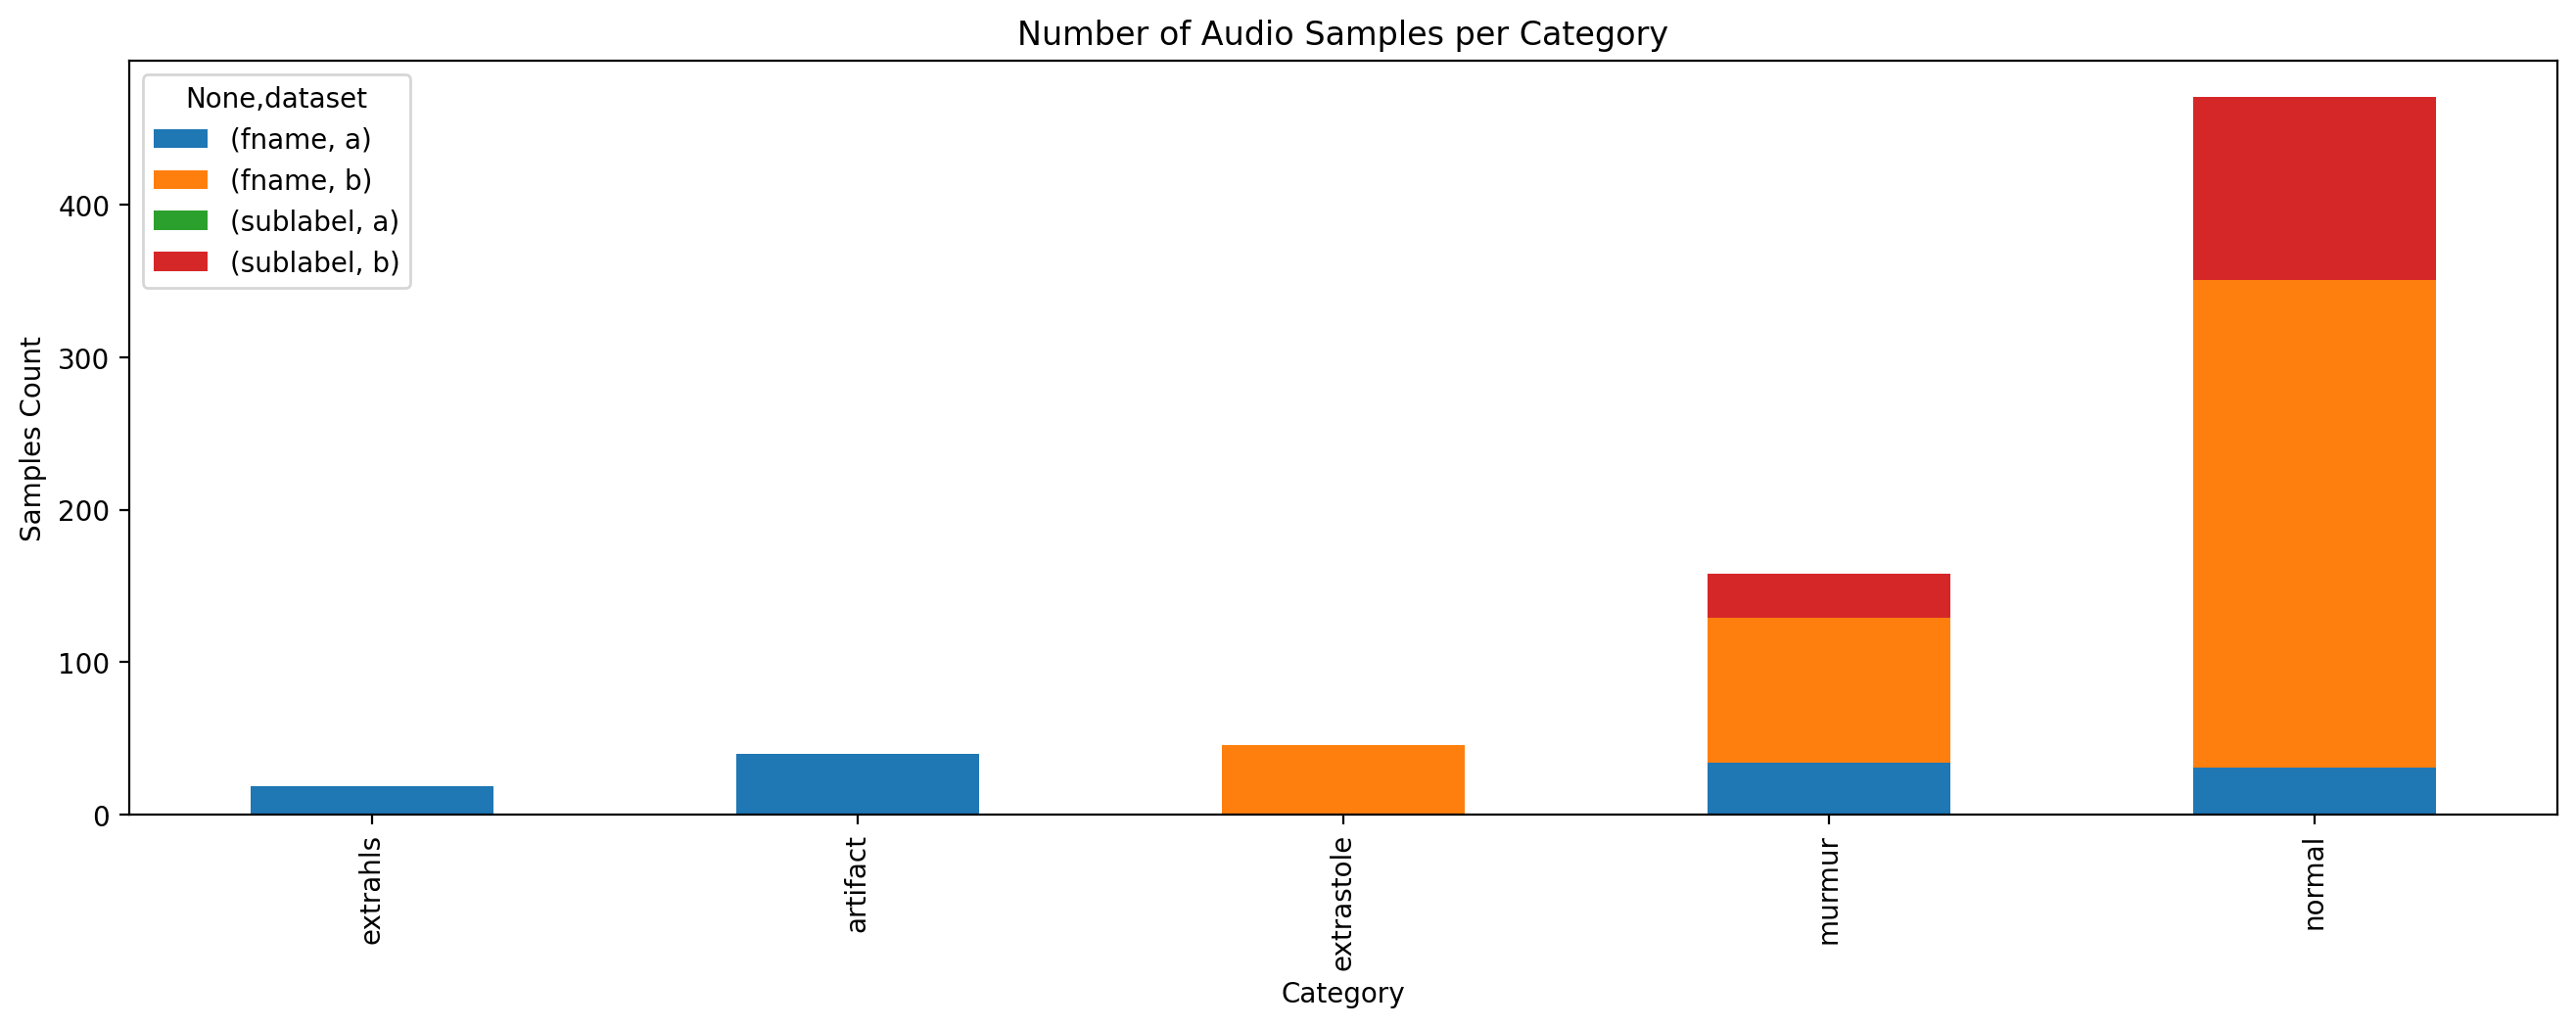

In [ ]:
# visualize data distribution by category
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

In [ ]:
print('Minimum samples per category = ', min(train_ab.label.value_counts()))
print('Maximum samples per category = ', max(train_ab.label.value_counts()))

Minimum samples per category =  19
Maximum samples per category =  351


In [ ]:
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"

In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file)

In [ ]:
# Load use wave
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [ ]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


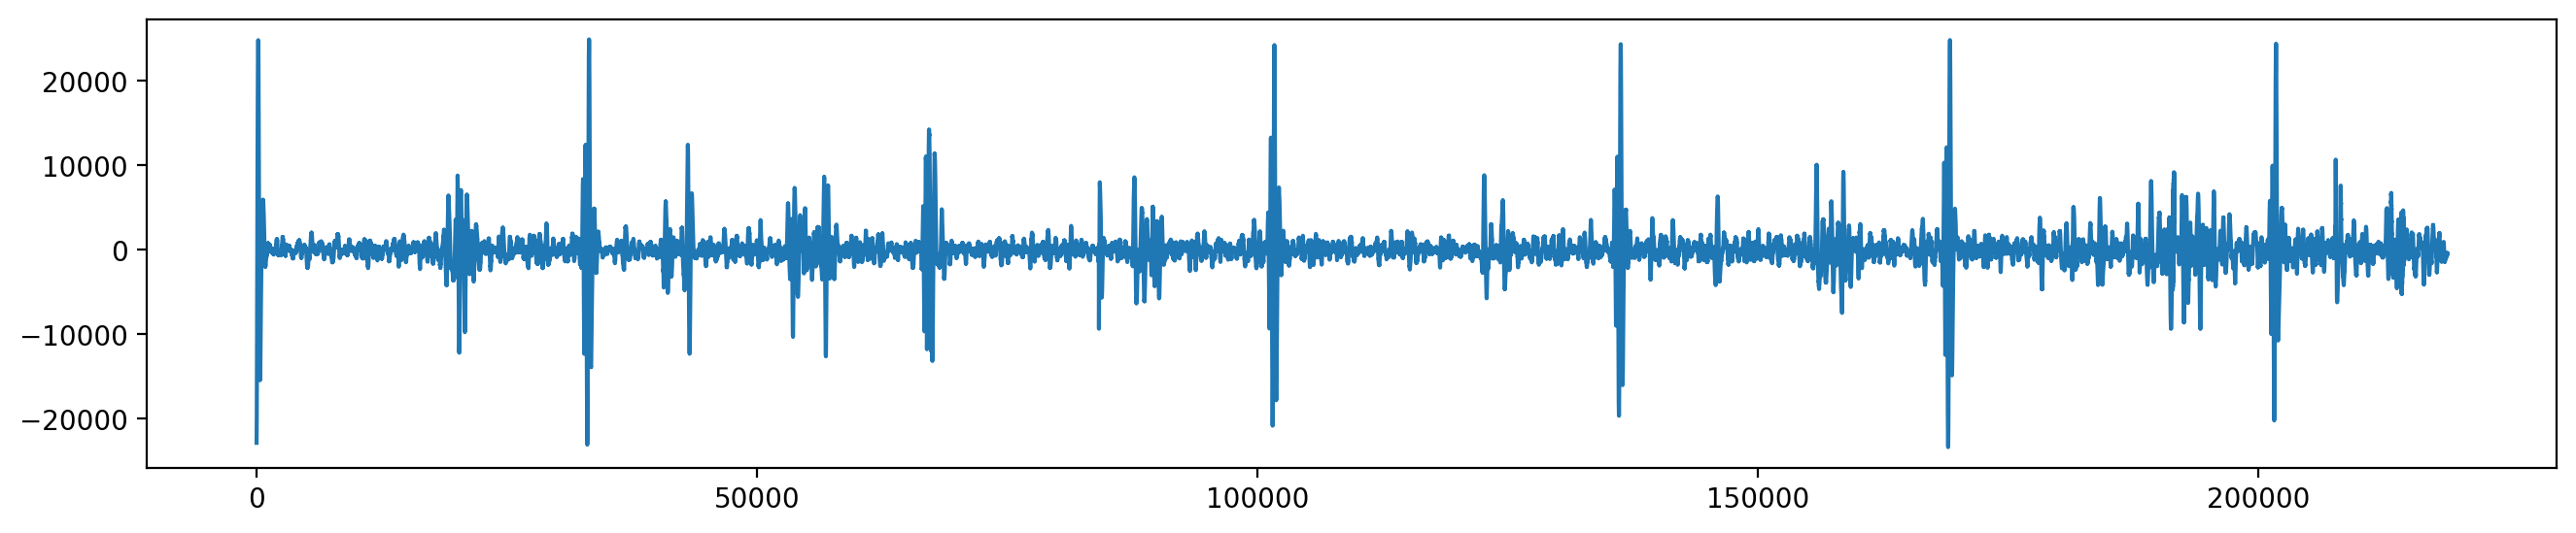

In [ ]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

In [ ]:
y, sr = librosa.load(normal_file, duration=5)   #default sampling rate is 22 HZ
dur = librosa.get_duration(y=y, sr=sr)
print ("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


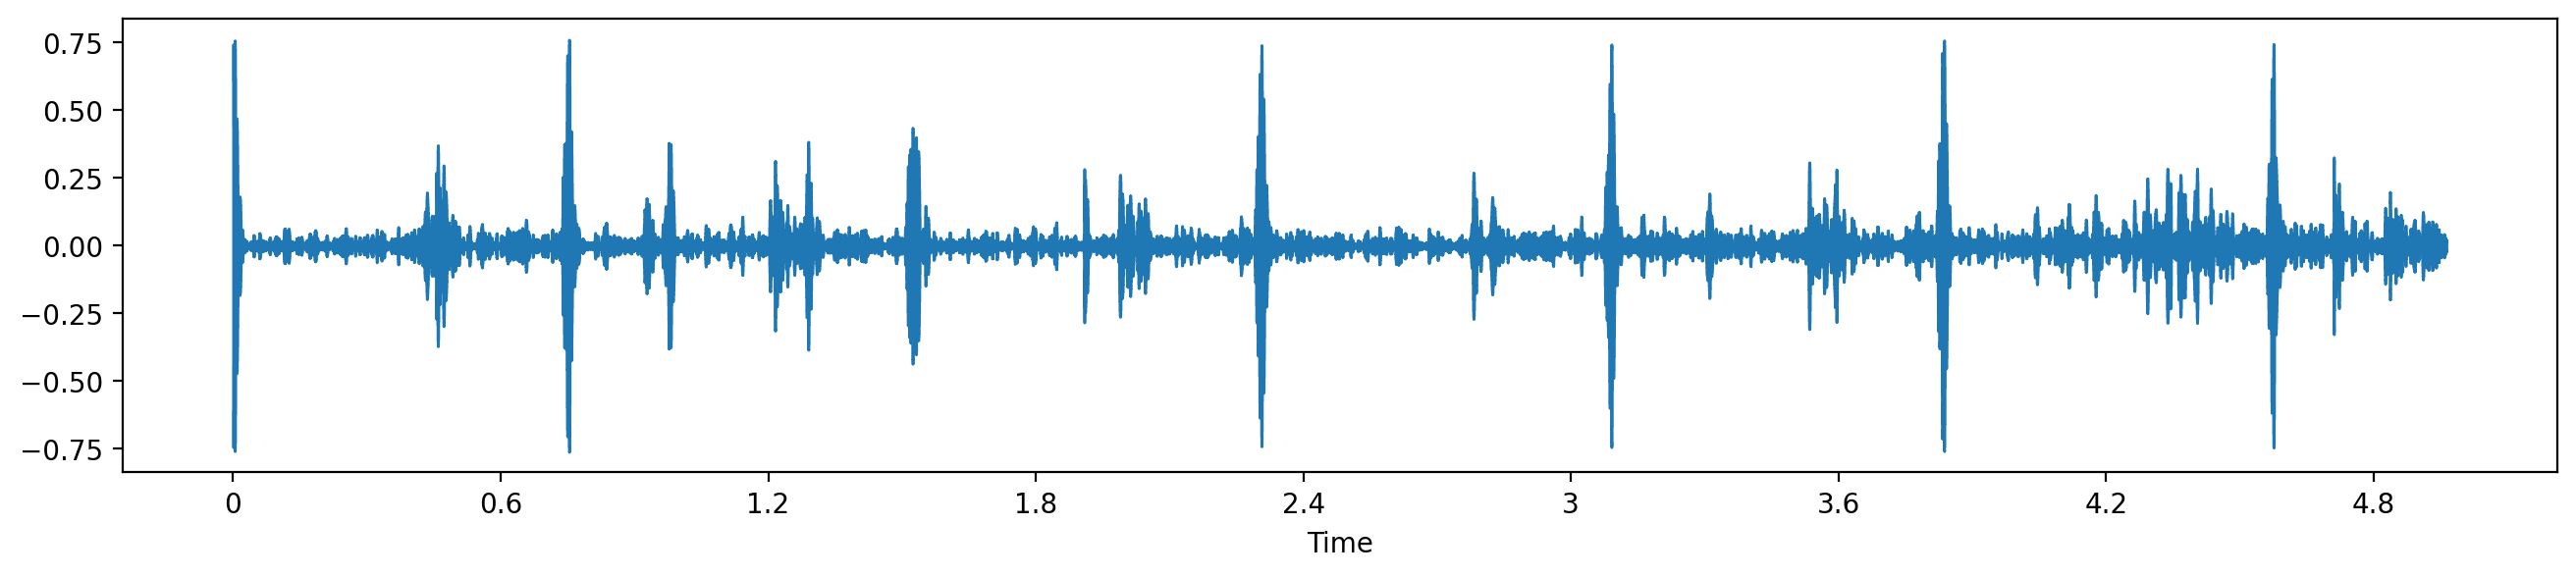

In [ ]:
# librosa plot
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y, sr=sr)

In [ ]:
####2. Murmur

# murmur case
murmur_file=INPUT_DIR+"/set_a/murmur__201108222242.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [ ]:
import IPython.display as ipd
ipd.Audio(murmur_file)

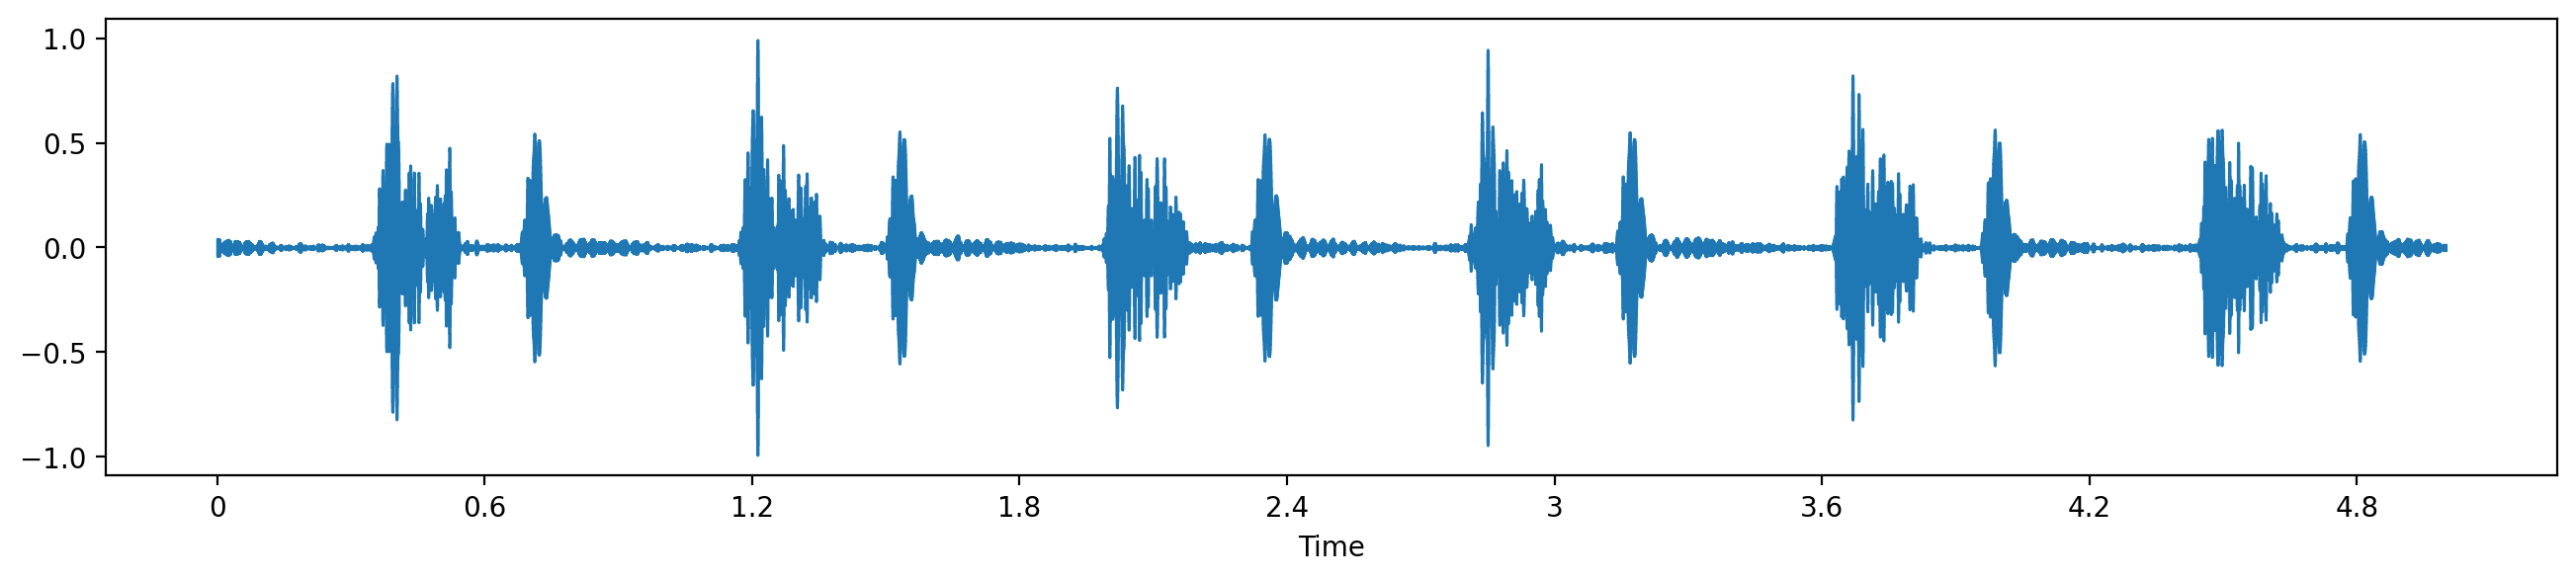

In [ ]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y2, sr=sr2)

In [ ]:
# Extrasystole case
extrastole_file=INPUT_DIR+"/set_b/extrastole__261_1309353556003_C.wav"
y3, sr3 = librosa.load(extrastole_file, duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y3.shape,sr3)

duration: 4.963809523809524
(110250,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(extrastole_file)

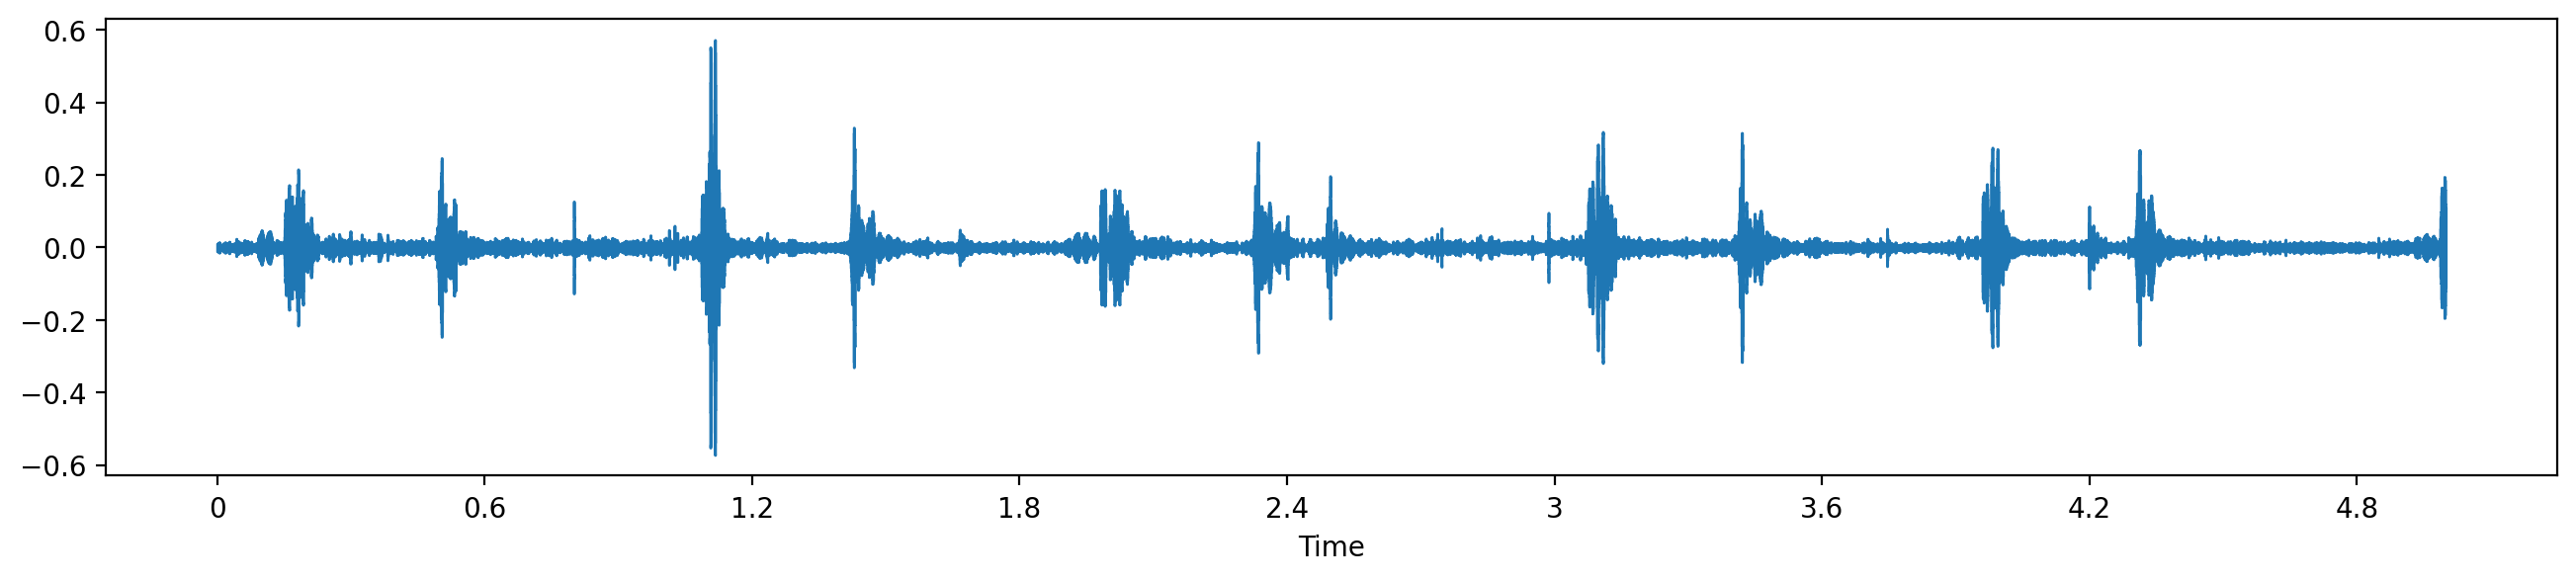

In [ ]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y3, sr=sr3)

In [ ]:
# sample file
artifact_file=INPUT_DIR+"/set_a/artifact__201106110909.wav"
y4, sr4 = librosa.load(artifact_file, duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y4.shape,sr4)

duration: 4.963809523809524
(110250,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(artifact_file)

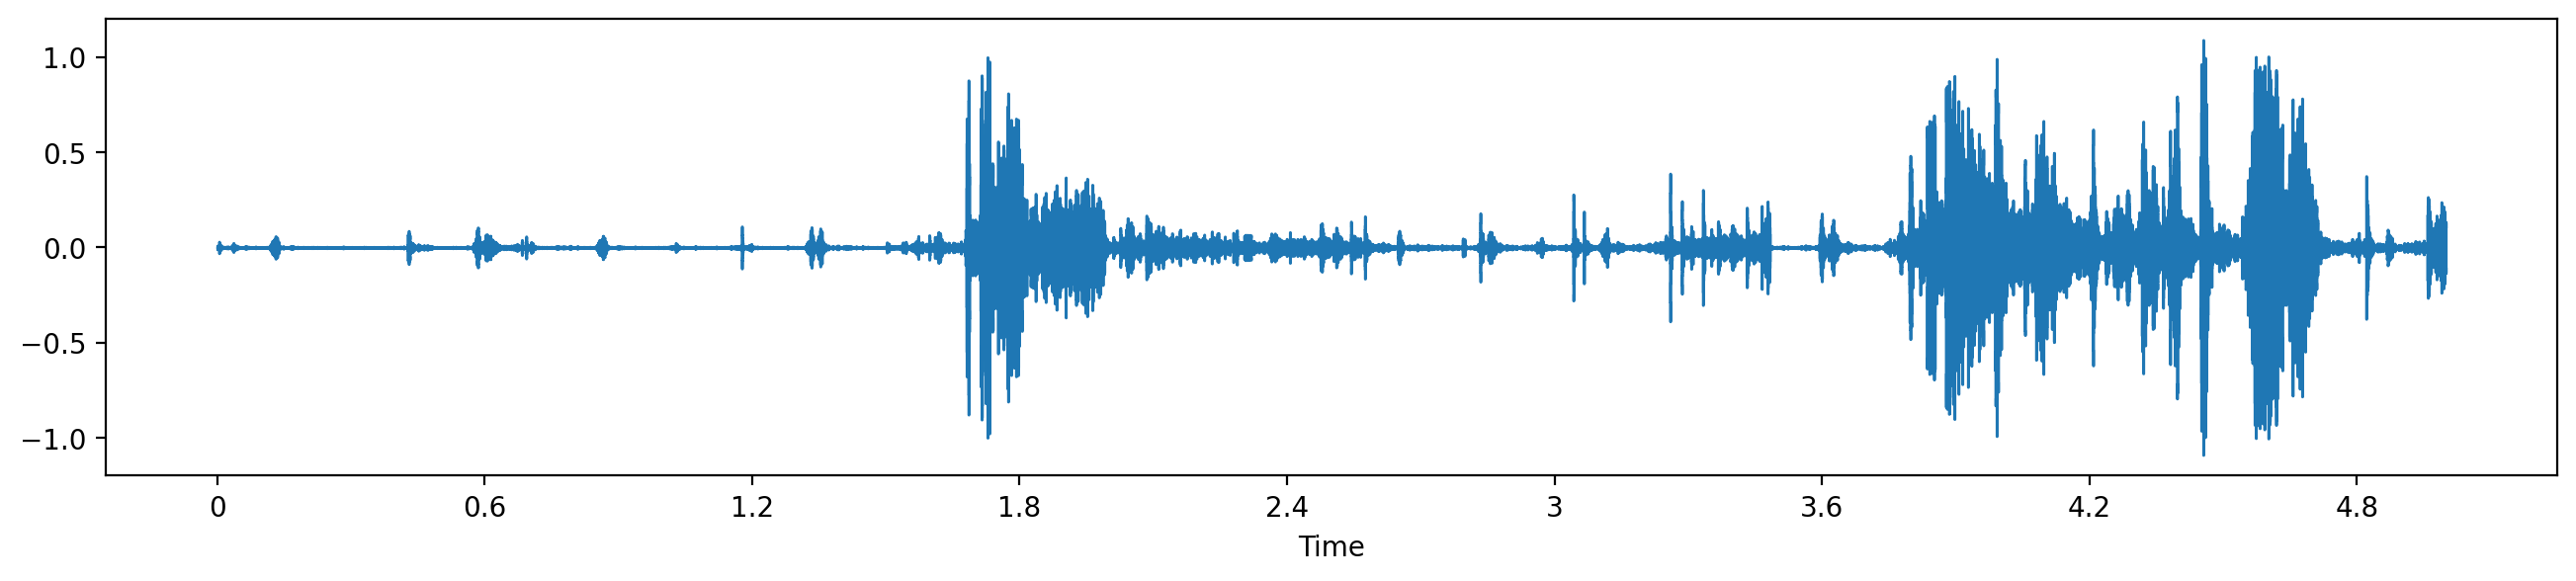

In [ ]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y4, sr=sr4)

In [ ]:
# sample file
extrahls_file=INPUT_DIR+"/set_a/extrahls__201102241217.wav"
y5, sr5 = librosa.load(extrahls_file, duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y5.shape,sr5)

duration: 4.963809523809524
(110250,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(extrahls_file)

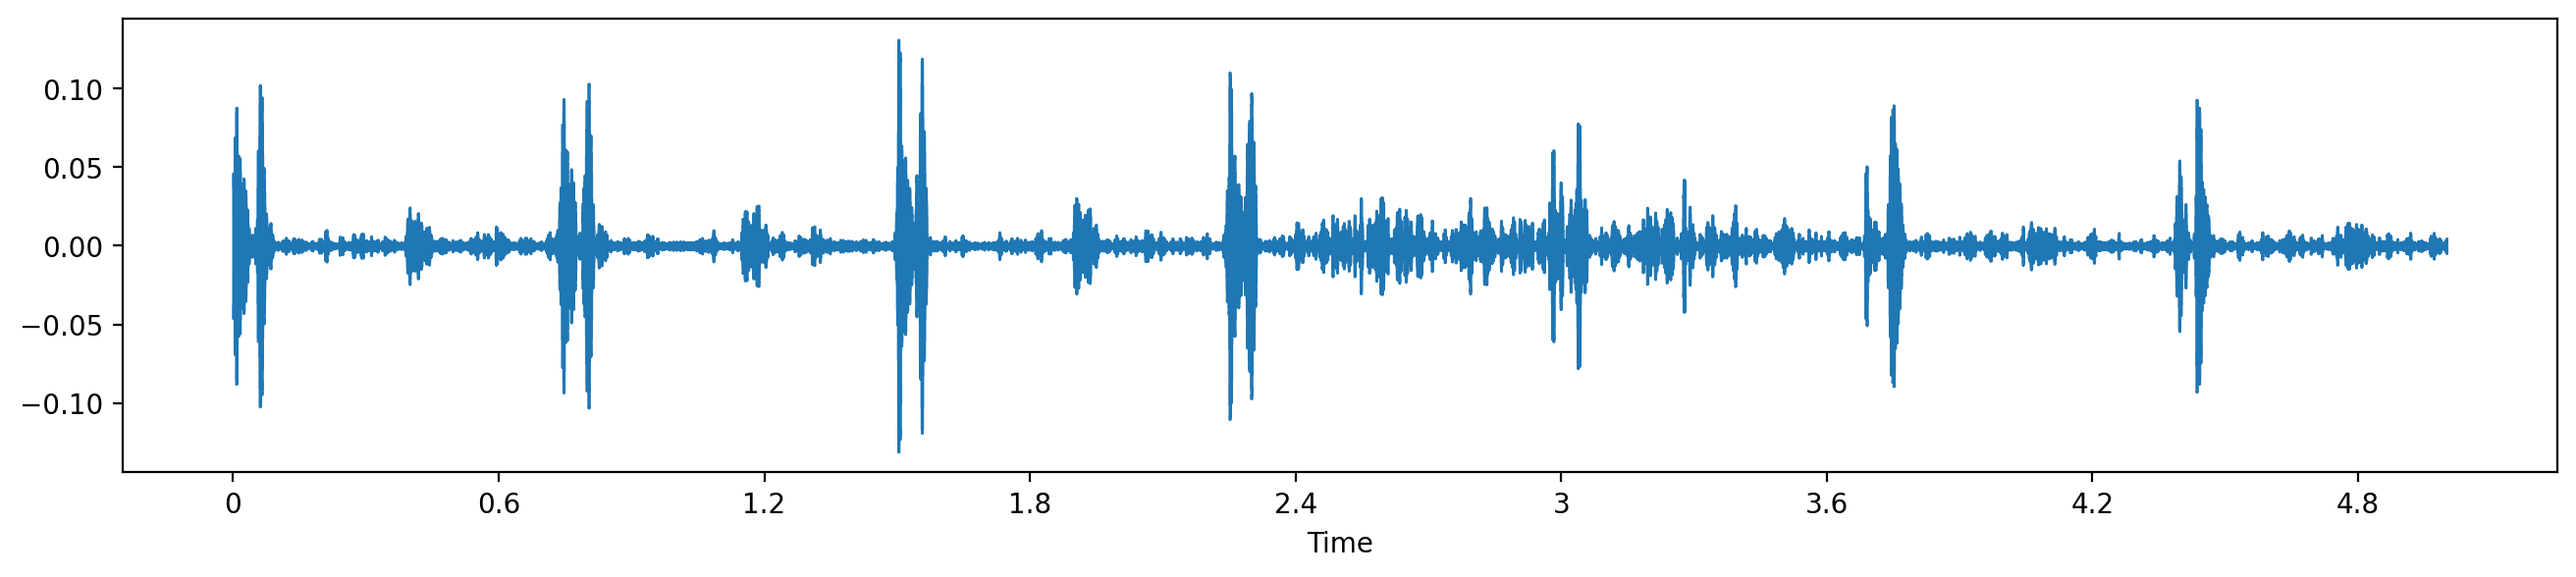

In [ ]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y5, sr=sr5)

In [ ]:
# Here's a sample generate mfccs from a wave file
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-8.1913383e+01 -1.4807559e+02 -4.0729141e+02 ... -3.6786765e+02
  -3.7412061e+02 -3.7847031e+02]
 [ 1.2379559e+02  1.2622456e+02  1.3922583e+02 ...  1.5123857e+02
   1.6177921e+02  1.6117076e+02]
 [ 1.7456497e+01  1.9744457e+01  1.9956833e+01 ...  2.9298073e+01
   2.5672840e+01  3.3723251e+01]
 ...
 [-7.1166635e-01 -1.5279514e-01 -1.3570656e+00 ... -2.9591602e-01
   3.5141253e-01  2.2013893e+00]
 [-2.7901683e+00 -2.1342328e+00  4.8859596e-02 ...  2.5581994e+00
   3.4908652e-03  5.4476895e+00]
 [-1.3884723e-01  3.3570039e-01 -2.9419873e+00 ...  2.3936687e+00
  -1.4753829e+00  3.3484679e-01]]


In [ ]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-6.1982685e+01 -1.2800836e+02 -3.9028296e+02 ... -3.5058392e+02
  -3.5407178e+02 -3.5892279e+02]
 [ 1.1376016e+02  1.1646743e+02  1.3576584e+02 ...  1.4986195e+02
   1.5767870e+02  1.5809064e+02]
 [ 2.1968613e+01  2.4365150e+01  1.1875887e+01 ...  2.0178364e+01
   1.8738571e+01  2.7622364e+01]
 ...
 [-1.3763438e+00 -7.9267144e-01 -2.0632422e+00 ...  2.9104042e+00
  -1.4185039e+00  1.5542839e+00]
 [-2.6494286e+00 -2.2966690e+00 -3.4821877e+00 ...  1.3711340e+00
   3.4652799e-02 -1.5800276e+00]
 [-4.1403532e+00 -4.1632414e+00 -1.6855989e+00 ...  4.1955805e-01
   6.4381826e-01 -3.5052786e+00]]


In [ ]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

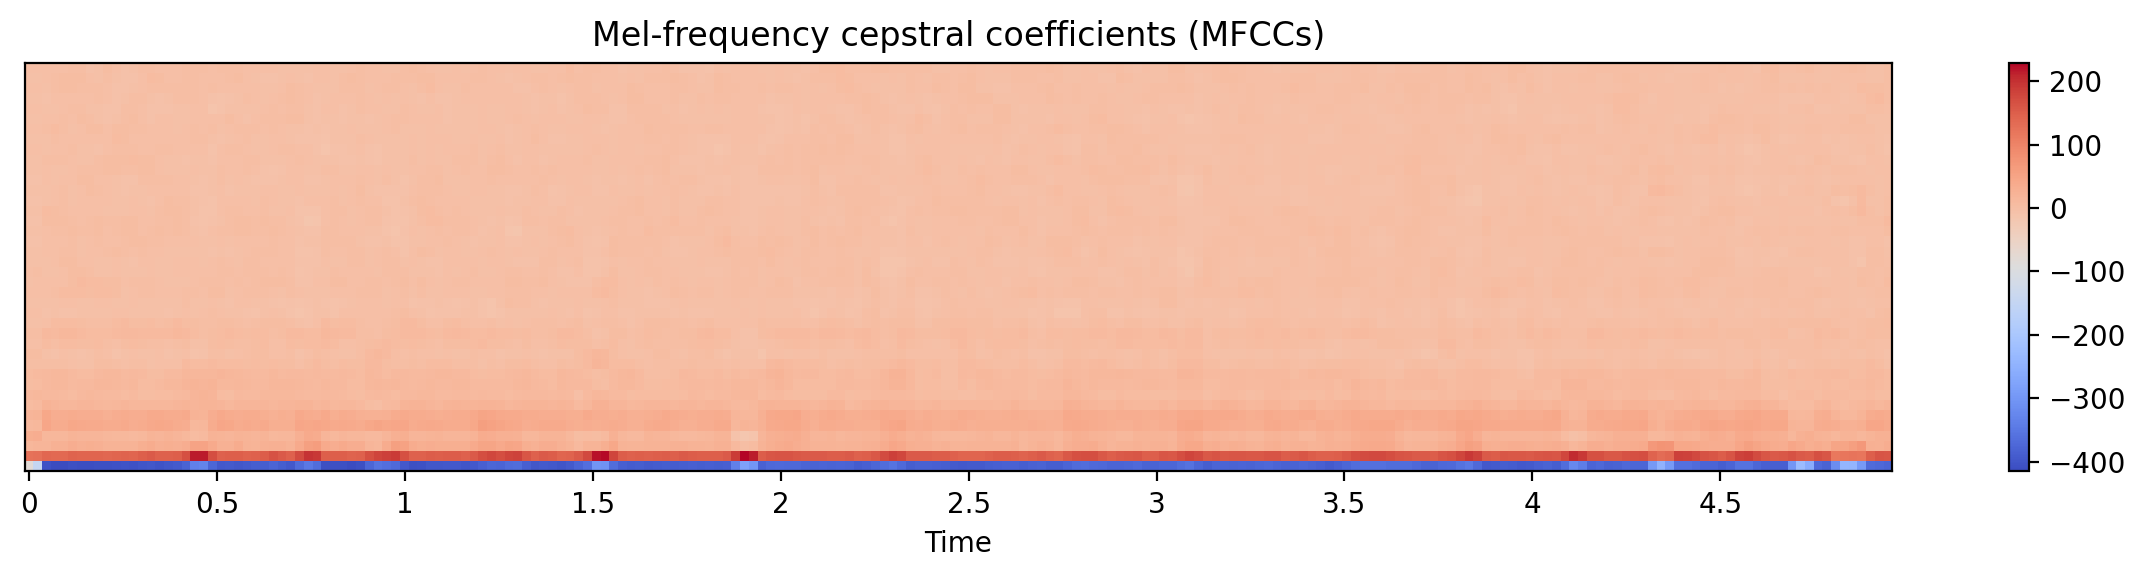

In [ ]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

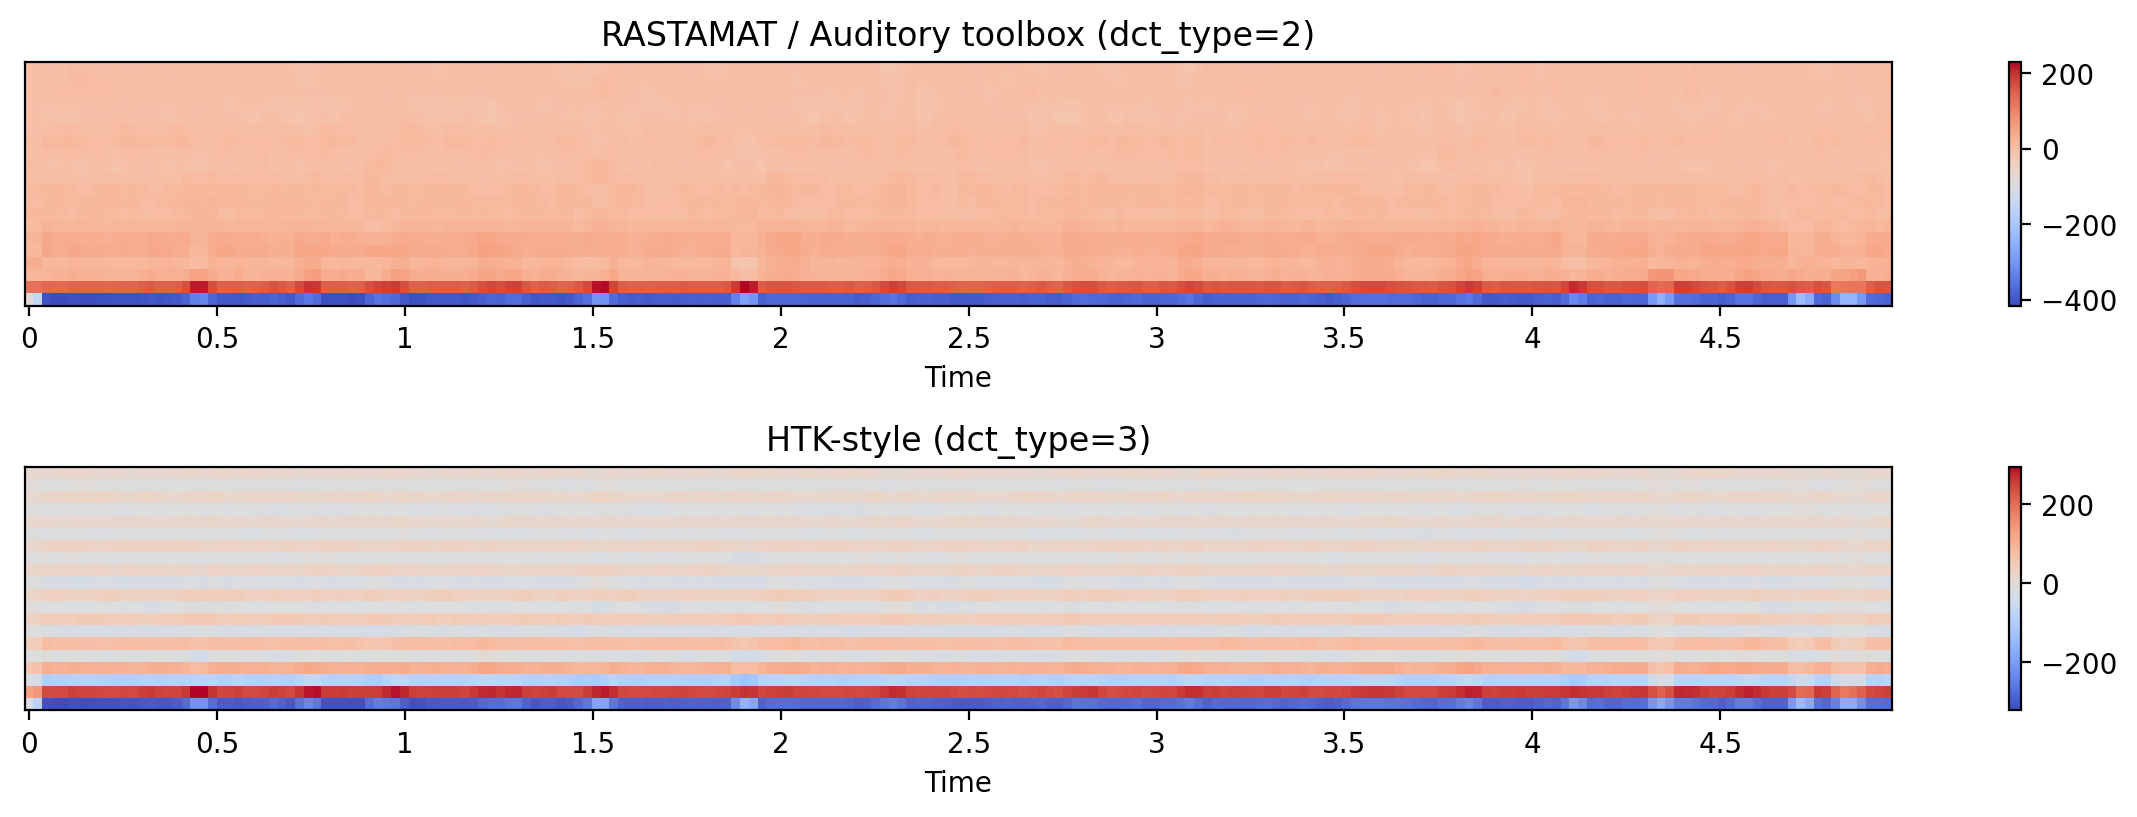

In [ ]:
# Compare different DCT bases
m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)

#m_dct1 = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
plt.figure(figsize=(12, 6))
#plt.subplot(3, 1, 1)
#librosa.display.specshow(m_dct1, x_axis='time')
#plt.title('Discrete cosine transform (dct_type=1)')
#plt.colorbar()
colormap = 'viridis'
m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
plt.subplot(3, 1, 2)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(m_htk, x_axis='time')
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()

In [ ]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.55573696,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.80807256,
       3.85451247, 4.13315193, 4.36535147, 4.59755102, 4.73687075,
       4.85297052])

In [ ]:
# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

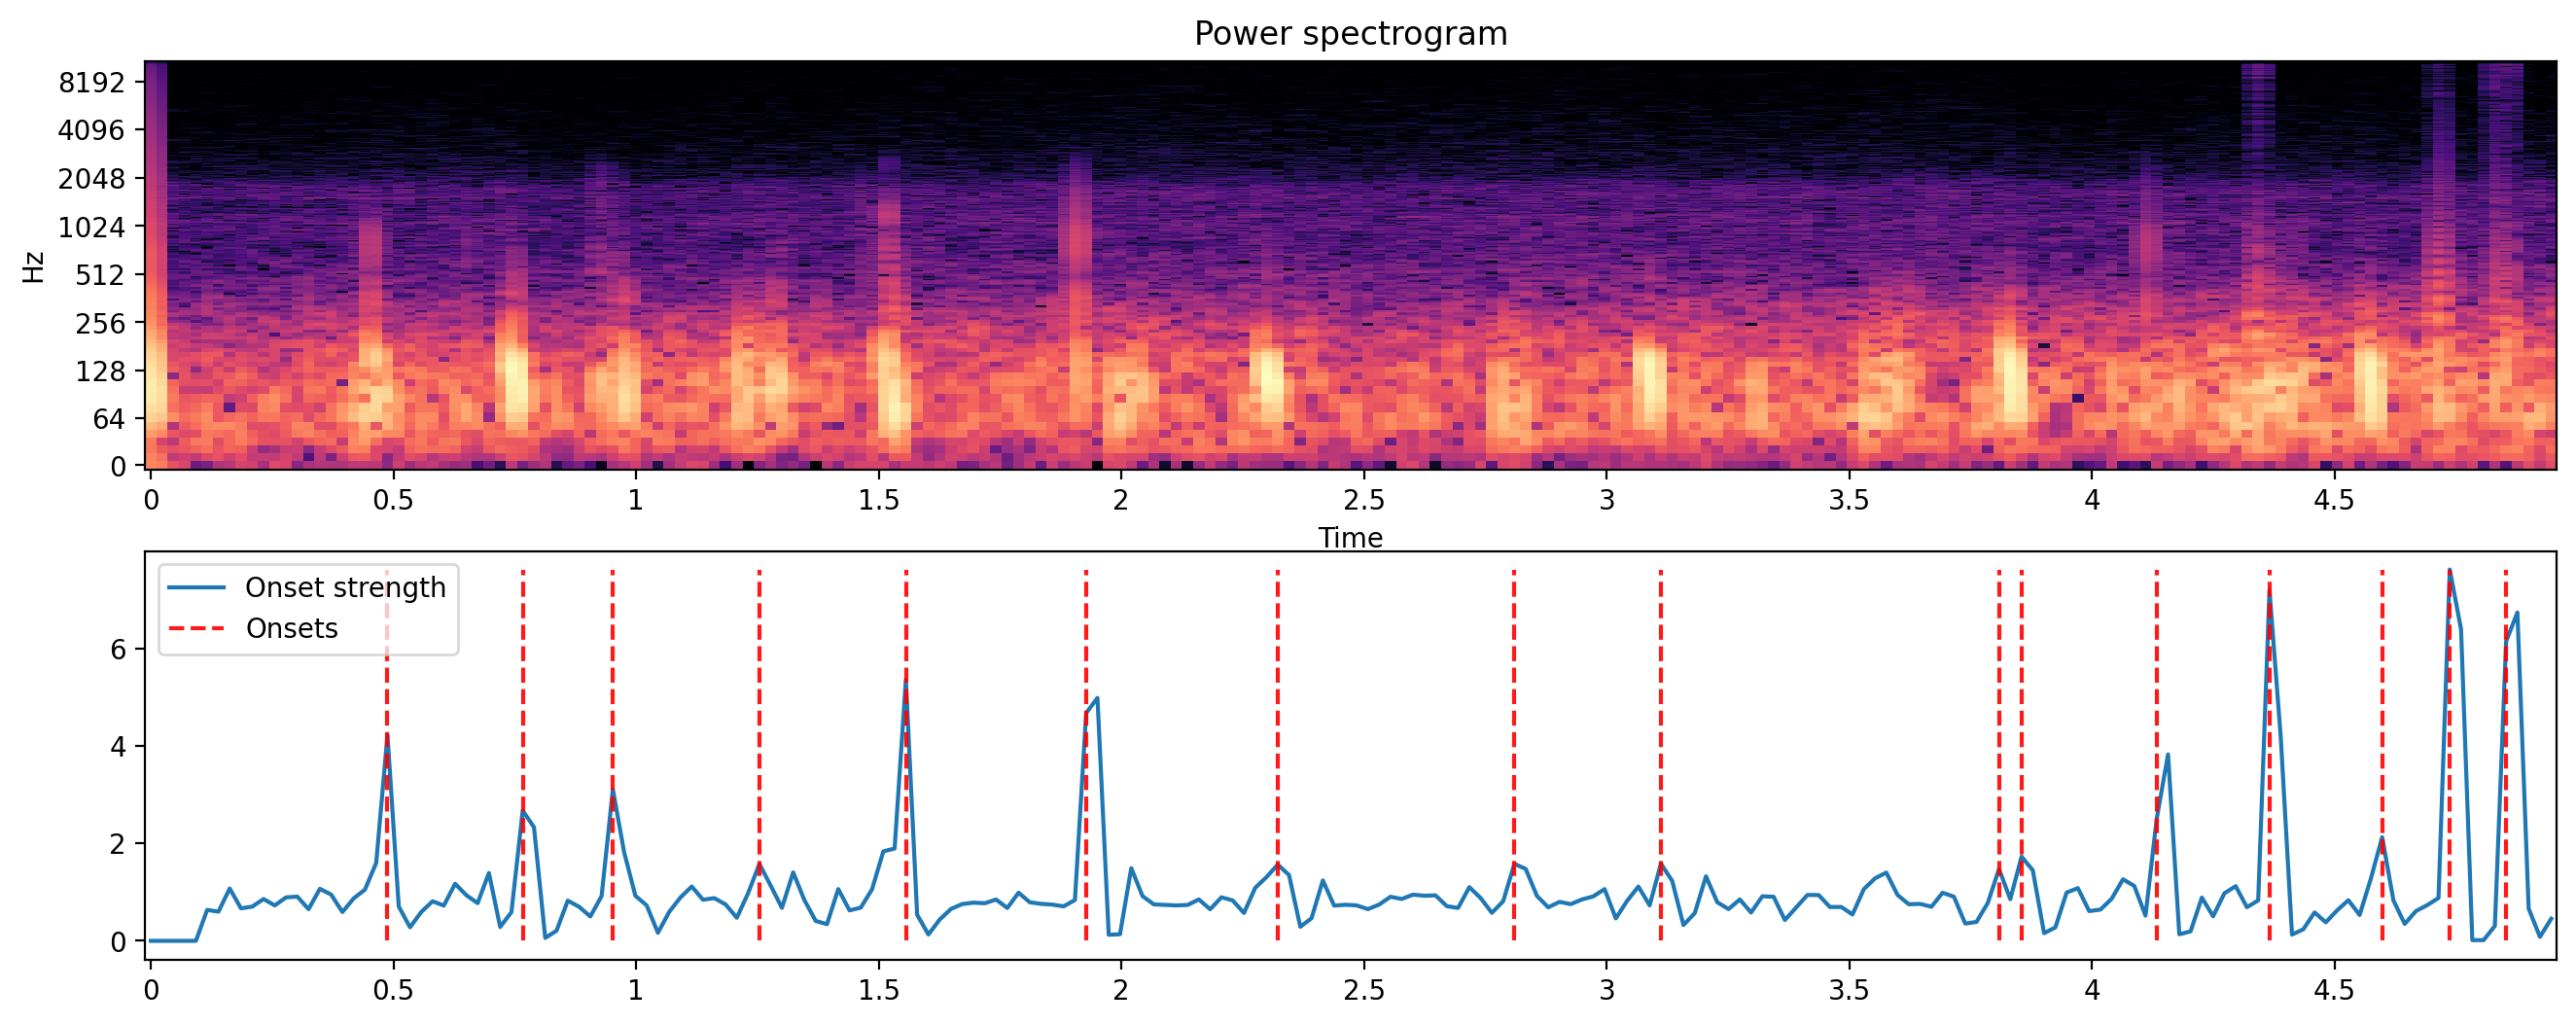

In [ ]:
# visualize it
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
colormap_spectrogram = 'viridis'
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log', cmap=colormap_spectrogram)
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength', color='blue')
plt.vlines(times[onset_frames], 0, o_env.max(), color='red', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

In [ ]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv, backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
# Backtrack the events using the RMS values
rms = librosa.feature.rms(S=np.abs(librosa.stft(y=y)))
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

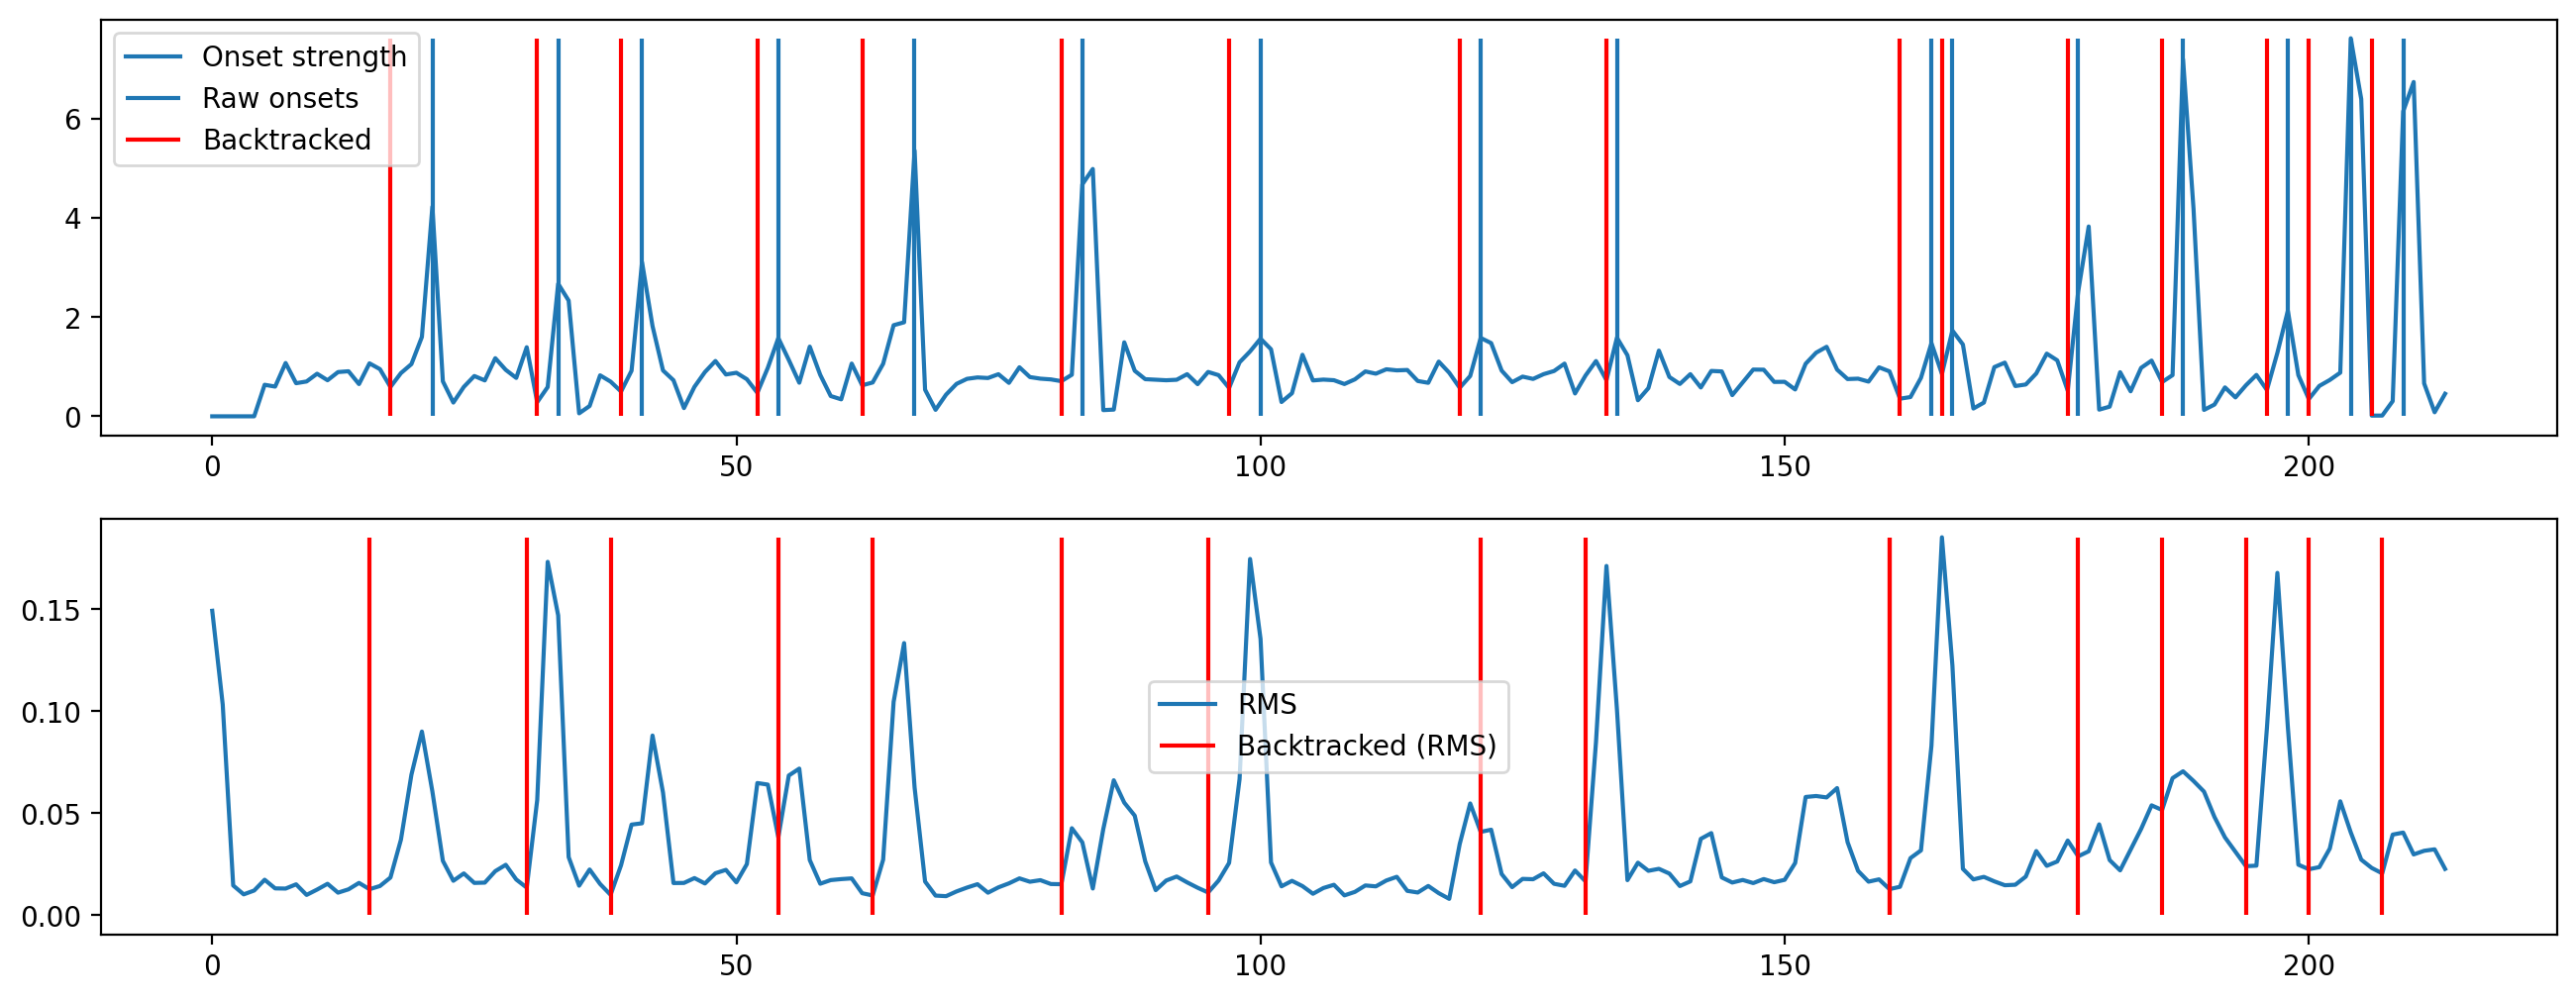

In [ ]:
# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(oenv, label='Onset strength')
plt.vlines(onset_raw, 0, oenv.max(), label='Raw onsets')
plt.vlines(onset_bt, 0, oenv.max(), label='Backtracked', color='r')
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(2,1,2)
plt.plot(rms[0], label='RMS')
plt.vlines(onset_bt_rms, 0, rms.max(), label='Backtracked (RMS)', color='r')
plt.legend(frameon=True, framealpha=0.75)

Text(0.5, 1.0, 'Sub-band onset strength')

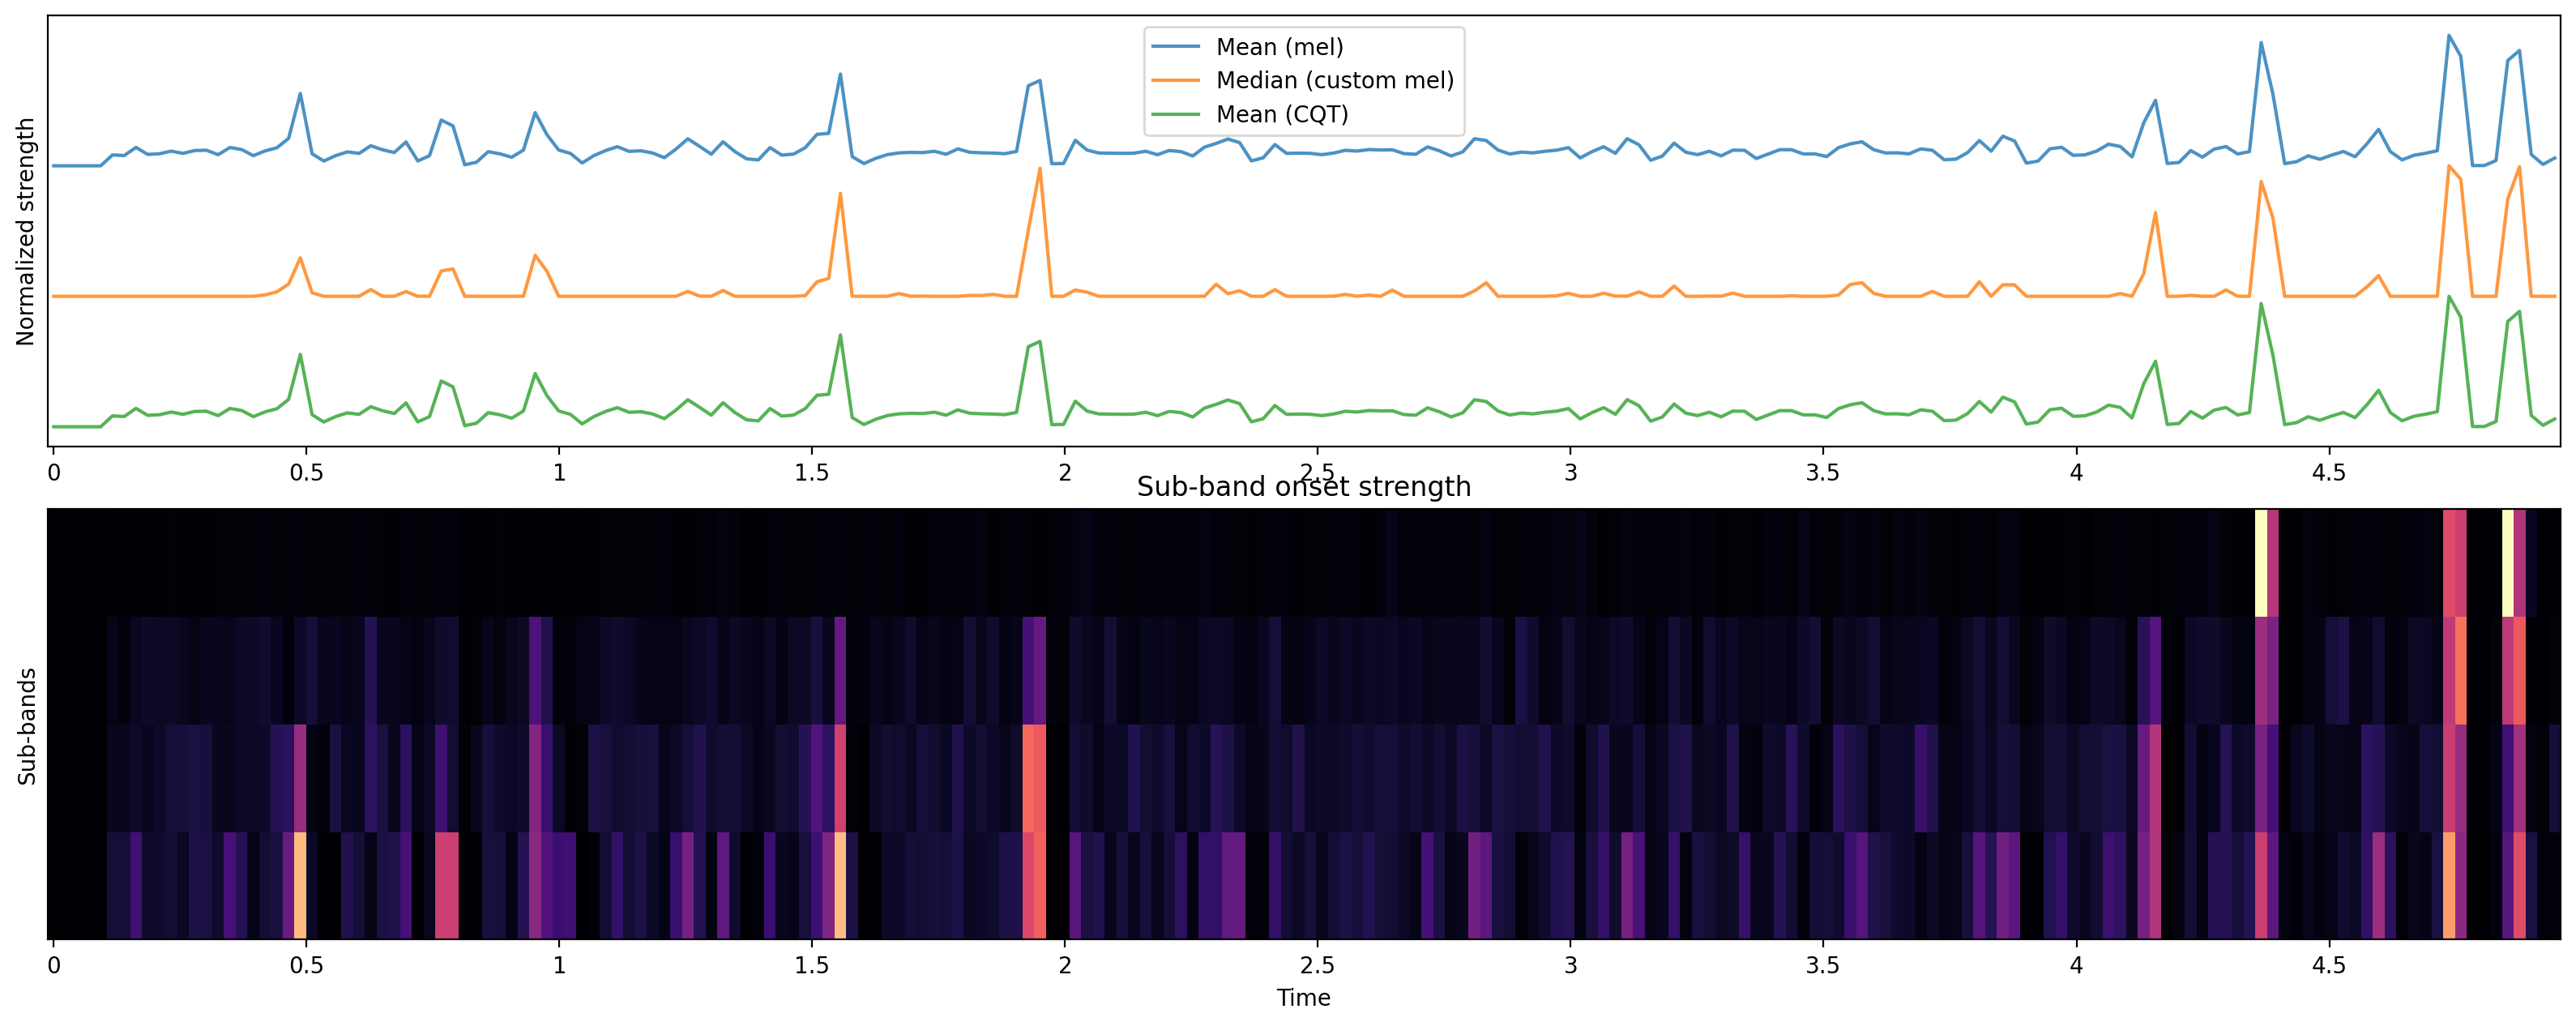

In [ ]:
D = np.abs(librosa.stft(y))
times = librosa.frames_to_time(np.arange(D.shape[1]))

plt.figure(figsize=(16, 6))
#ax1 = plt.subplot(2, 1, 1)
#librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),y_axis='log', x_axis='time')
#plt.title('Power spectrogram')

# Construct a standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.subplot(2, 1, 1, sharex=ax1)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,label='Mean (mel)')

# median
onset_env = librosa.onset.onset_strength(y=y, sr=sr,aggregate=np.median,fmax=8000, n_mels=256)
plt.plot(times, 1+ (onset_env/onset_env.max()), alpha=0.8,label='Median (custom mel)')

# Constant-Q spectrogram instead of Mel
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.plot(times, onset_env / onset_env.max(), alpha=0.8,label='Mean (CQT)')
plt.legend(frameon=True, framealpha=0.75)
plt.ylabel('Normalized strength')
plt.yticks([])
plt.axis('tight')
plt.tight_layout()

onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr, channels=[0, 32, 64, 96, 128])
#plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 2)
librosa.display.specshow(onset_subbands, x_axis='time')
plt.ylabel('Sub-bands')
plt.title('Sub-band onset strength')

In [ ]:
print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))

Number of training examples= 832   Number of classes= 6


In [ ]:
from numpy.ma.core import size
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast')
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data


# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length = int(sr*duration)
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration )
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(data=X, size=input_length)
            #normalized raw audio
            # y = audio_norm(y)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)
            print(mfccs)
        feature = np.array(mfccs).reshape((-1,1))
        data.append(feature)
    return data




In [ ]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [ ]:
# load dataset-a, keep them separate for testing purpose
import os, fnmatch

A_folder=INPUT_DIR+'/set_a/'
# set-a
sr = 16000
A_artifact_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder, file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

load file  /content/HeartBeatHarmonics/Input/set_a/artifact__201106211041.wav
fixing audio lenght : artifact__201106211041.wav
load file  /content/HeartBeatHarmonics/Input/set_a/artifact__201106161019.wav
fixing audio lenght : artifact__201106161019.wav
load file  /content/HeartBeatHarmonics/Input/set_a/artifact__201106131835.wav
fixing audio lenght : artifact__201106131835.wav
load file  /content/HeartBeatHarmonics/Input/set_a/artifact__201106121445.wav
fixing audio lenght : artifact__201106121445.wav
load file  /content/HeartBeatHarmonics/Input/set_a/artifact__201106161219.wav
fixing audio lenght : artifact__201106161219.wav
load file  /content/HeartBeatHarmonics/Input/set_a/artifact__201106131834.wav
fixing audio lenght : artifact__201106131834.wav
load file  /content/HeartBeatHarmonics/Input/set_a/artifact__201106212112.wav
fixing audio lenght : artifact__201106212112.wav
load file  /content/HeartBeatHarmonics/Input/set_a/artifact__201106110909.wav
fixing audio lenght : artifact__2

In [ ]:
%%time
# load dataset-b, keep them separate for testing purpose
B_folder=INPUT_DIR+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

load file  /content/HeartBeatHarmonics/Input/set_b/normal_noisynormal_271_1309369876160_D.wav
load file  /content/HeartBeatHarmonics/Input/set_b/normal_noisynormal_296_1311682952647_C.wav
load file  /content/HeartBeatHarmonics/Input/set_b/normal__300_1311772096120_C1.wav
fixing audio lenght : normal__300_1311772096120_C1.wav
load file  /content/HeartBeatHarmonics/Input/set_b/normal_noisynormal_284_1311168471850_B.wav
load file  /content/HeartBeatHarmonics/Input/set_b/normal__299_1311770522820_C.wav
fixing audio lenght : normal__299_1311770522820_C.wav
load file  /content/HeartBeatHarmonics/Input/set_b/normal_noisynormal_271_1309369876160_C.wav
fixing audio lenght : normal_noisynormal_271_1309369876160_C.wav
load file  /content/HeartBeatHarmonics/Input/set_b/normal__296_1311682952647_A1.wav
fixing audio lenght : normal__296_1311682952647_A1.wav
load file  /content/HeartBeatHarmonics/Input/set_b/normal_noisynormal_278_1311163365896_B.wav
load file  /content/HeartBeatHarmonics/Input/set_b

In [ ]:
#combine set-a and set-b
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds,
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  92 25


In [ ]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

In [ ]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (92,)
data size of the array: : 92
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  736
0

audio data shape:  (92, 40, 1)
data size of the array: : 3680
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  14720

training data shape:  (73, 40, 1)
training label shape:  (73, 3)

validation data shape:  (9, 40, 1)
validation label shape:  (9, 3)

test data shape:  (10, 40, 1)
test label shape:  (10, 3)


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint



In [ ]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

Build LSTM RNN model ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 29411 (114.89 KB)
Trainable params: 29411 (114.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train Model

In [ ]:
import numpy as np

# Check the shape of x_train and y_train
x_train_shape = x_train.shape
y_train_shape = y_train.shape

print("Shape of x_train:", x_train_shape)
print("Shape of y_train:", y_train_shape)

Shape of x_train: (73, 40, 1)
Shape of y_train: (73, 3)


In [ ]:
print("Training data shape:", x_train.shape)
print("Training label shape:", y_train.shape)
print("Validation data shape:", x_val.shape)
print("Validation label shape:", y_val.shape)

Training data shape: (73, 40, 1)
Training label shape: (73, 3)
Validation data shape: (9, 40, 1)
Validation label shape: (9, 3)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Load your data (replace with your actual data loading code)
x_train = np.random.rand(24, 218903)
y_train = np.random.randint(0, 3, (24, 3))
x_val = np.random.rand(3, 218903)
y_val = np.random.randint(0, 3, (3, 3))

# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
# Parameters
batch_size = 16
num_epochs = 10
MAX_BATCH = 16  # Define MAX_BATCH with your desired batch size
MAX_EPOCHS = 10  # Replace 10 with your desired number of epochs
MAX_PATIENT = 10  # Set the patience value to 10 (or any value you prefer)

# Data generator
def data_generator(data_x, data_y, batch_size):
    num_samples = data_x.shape[0]
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_x = data_x[batch_indices]
            batch_y = data_y[batch_indices]
            yield batch_x, batch_y

# Create a simple LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], 1)))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Checkpoint model weights
model_checkpoint = ModelCheckpoint('model_weights.h5', save_best_only=True)

# Create data generators
train_data_generator = data_generator(x_train, y_train, batch_size)
val_data_generator = data_generator(x_val, y_val, batch_size)

# Calculate steps_per_epoch
steps_per_epoch = max(len(x_train) // batch_size, 1)  # Ensure it's at least 1

# Train the model
model.fit(train_data_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=[model_checkpoint])

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

print("Training started... please wait.")
# callbacks
callback = [ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
            ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

# training
history = model.fit(x_train, y_train,
                    batch_size=MAX_BATCH,
                    epochs=MAX_EPOCHS,
                    verbose=0,
                    validation_data=(x_val, y_val),
                    callbacks=callback)

print("Training finished!")

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 3.3507 - accuracy: 0.3750

1/1 [==============================] - 98s 98s/step - loss: 3.3507 - accuracy: 0.3750
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 4.5353 - accuracy: 0.2500

1/1 [==============================] - 69s 69s/step - loss: 4.5353 - accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 3.6956 - accuracy: 0.3125

1/1 [==============================] - 77s 77s/step - loss: 3.6956 - accuracy: 0.3125
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 3.8167 - accuracy: 0.5000

1/1 [==============================] - 69s 69s/step - loss: 3.8167 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 4.0864 - accuracy: 0.6250

1/1 [==============================] - 75s 75s/step - loss: 4.0864 - accuracy: 0.6250
Epoch 6/10
1/1 [==============================] - ETA: 0s - loss: 3.0242 - accuracy: 0.3750

1/1 [==============================] - 70s 70s/step - loss: 3.0242 - accuracy: 0.3750
Epoch 7/10
1/1 [==============================] - ETA: 0s - loss: 3.6116 - accuracy: 0.5000

1/1 [==============================] - 82s 82s/step - loss: 3.6116 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 3.9582 - accuracy: 0.6250

1/1 [==============================] - 69s 69s/step - loss: 3.9582 - accuracy: 0.6250
Epoch 9/10
1/1 [==============================] - ETA: 0s - loss: 3.8973 - accuracy: 0.5625

1/1 [==============================] - 77s 77s/step - loss: 3.8973 - accuracy: 0.5625
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 3.3751 - accuracy: 0.5000

1/1 [==============================] - 12s 12s/step - loss: 3.1444 - accuracy: 0.6667
Validation Loss: 3.144437789916992, Validation Accuracy: 0.6666666865348816
Training started... please wait.

Epoch 1: loss improved from inf to 3.72747, saving model to ./best_model_trained.hdf5

Epoch 2: loss did not improve from 3.72747

Epoch 3: loss did not improve from 3.72747

Epoch 4: loss did not improve from 3.72747

Epoch 5: loss did not improve from 3.72747

Epoch 6: loss did not improve from 3.72747

Epoch 7: loss did not improve from 3.72747

Epoch 8: loss did not improve from 3.72747

Epoch 9: loss did not improve from 3.72747

Epoch 10: loss did not improve from 3.72747
Training finished!


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load your data (replace with your actual data loading code)
x_train = np.random.rand(24, 218903)  # Your training data
y_train = np.random.randint(0, 3, (24, 3))  # Your training labels

# Parameters
batch_size = 16
num_epochs = 10

# Reshape the input data to have the time steps dimension
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

# Create a simple LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, x_train.shape[2])))  # Update the input shape

# Add the rest of your model layers as needed
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using your data generator or actual data
# Replace this with your actual training code
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs)

# Keras reported accuracy:
#model.add(LSTM(64, input_shape=(x_train.shape[1], 1), implementation=2))

score = model.evaluate(x_train, y_train, verbose=0)
print ("model train data score       : ",round(score[1]*100) , "%")
# Load your test data (replace with your actual test data)
x_test = np.random.rand(3, 218903)  # Your test data
y_test = np.random.randint(0, 3, (3, 3))  # Your test labels

# Reshape the test data to have the time steps dimension
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

# Evaluate the model on the test data
score = model.evaluate(x_test, y_test, verbose=0)

# Print the test accuracy
print("model test data score: ", round(score[1] * 100), "%")

score = model.evaluate(x_test, y_test, verbose=0)
print ("model test data score        : ",round(score[1]*100) , "%")
# Load your validation data (replace with your actual validation data)
x_val = np.random.rand(3, 218903)  # Your validation data
y_val = np.random.randint(0, 3, (3, 3))  # Your validation labels

# Reshape the validation data to have the time steps dimension
x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])

# Evaluate the model on the validation data
score = model.evaluate(x_val, y_val, verbose=0)

# Print the validation accuracy
print("model validation data score: ", round(score[1] * 100), "%")

score = model.evaluate(x_val, y_val, verbose=0)
print ("model validation data score  : ", round(score[1]*100), "%")
# Load your test data (replace with your actual test data)
test_x = np.random.rand(3, 218903)  # Your test data
test_y = np.random.randint(0, 3, (3, 3))  # Your test labels

# Reshape the test data to have the time steps dimension
test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])

# Evaluate the model on the test data
score = model.evaluate(test_x, test_y, verbose=0)

# Print the test accuracy
print("model test data score: ", round(score[1] * 100), "%")

score = model.evaluate(test_x, test_y, verbose=0)
print ("model unlabeled data score   : ", round(score[1]*100), "%")

Epoch 1/10
2/2 [==============================] - 8s 967ms/step - loss: 3.2569 - accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 2s 964ms/step - loss: 3.4170 - accuracy: 0.6250
Epoch 3/10
2/2 [==============================] - 2s 957ms/step - loss: 3.2922 - accuracy: 0.6250
Epoch 4/10
2/2 [==============================] - 3s 1s/step - loss: 3.3002 - accuracy: 0.6250
Epoch 5/10
2/2 [==============================] - 2s 961ms/step - loss: 3.3006 - accuracy: 0.6250
Epoch 6/10
2/2 [==============================] - 2s 984ms/step - loss: 3.3008 - accuracy: 0.6250
Epoch 7/10
2/2 [==============================] - 2s 963ms/step - loss: 3.3011 - accuracy: 0.6250
Epoch 8/10
2/2 [==============================] - 2s 963ms/step - loss: 3.3015 - accuracy: 0.6250
Epoch 9/10
2/2 [==============================] - 2s 970ms/step - loss: 3.3016 - accuracy: 0.6250
Epoch 10/10
2/2 [==============================] - 3s 1s/step - loss: 3.3023 - accuracy: 0.6250
model train data score   


Epoch 1: loss improved from inf to 3.30168, saving model to ./best_model_trained.hdf5

Epoch 2: loss improved from 3.30168 to 3.30059, saving model to ./best_model_trained.hdf5

Epoch 3: loss improved from 3.30059 to 3.29879, saving model to ./best_model_trained.hdf5

Epoch 4: loss improved from 3.29879 to 3.29639, saving model to ./best_model_trained.hdf5

Epoch 5: loss did not improve from 3.29639

Epoch 6: loss improved from 3.29639 to 3.29492, saving model to ./best_model_trained.hdf5

Epoch 7: loss improved from 3.29492 to 3.29234, saving model to ./best_model_trained.hdf5

Epoch 8: loss improved from 3.29234 to 3.29031, saving model to ./best_model_trained.hdf5

Epoch 9: loss improved from 3.29031 to 3.28849, saving model to ./best_model_trained.hdf5

Epoch 10: loss improved from 3.28849 to 3.28832, saving model to ./best_model_trained.hdf5
Training history:
{'loss': [3.30167555809021, 3.300591468811035, 3.2987897396087646, 3.296391248703003, 3.296675443649292, 3.294916391372680

<Figure size 2200x1000 with 0 Axes>

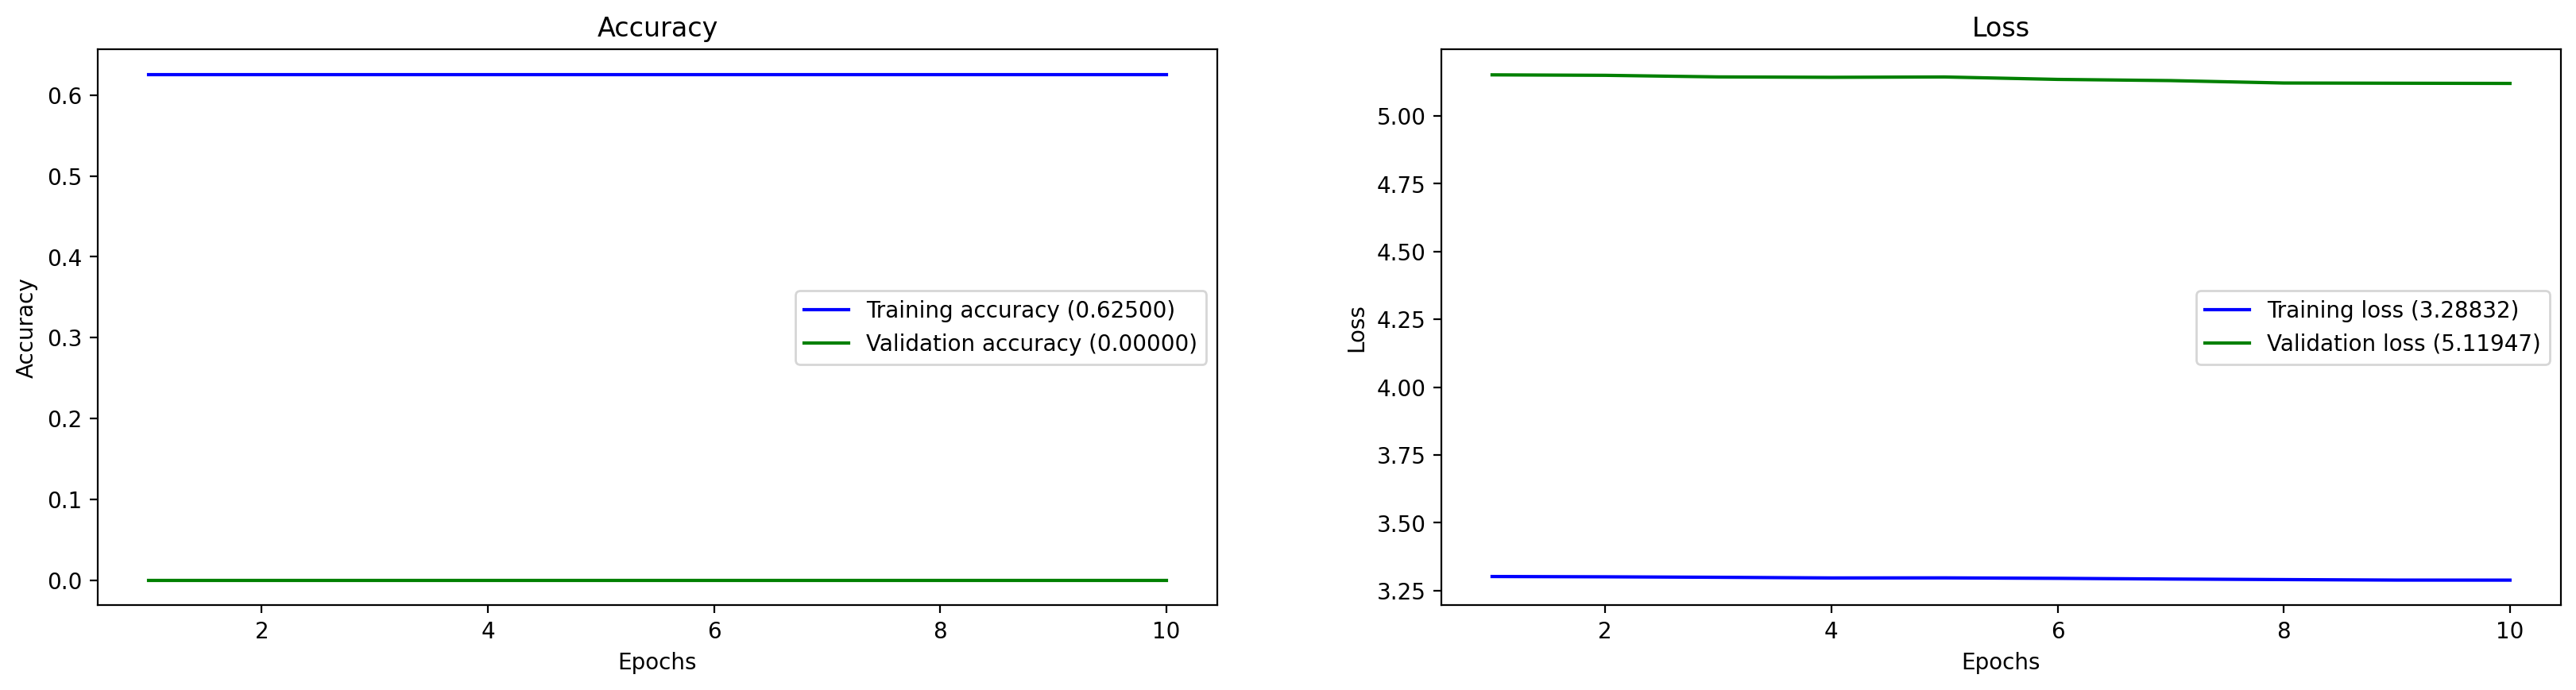

CPU times: user 40.6 s, sys: 33.1 s, total: 1min 13s
Wall time: 8min 22s


In [ ]:
%%time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#Plot Keras History
#Plot loss and accuracy for the training and validation set.
# Train the model and store the history
# callbacks
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
callback = [ReduceLROnPlateau(patience=10, verbose=1),
            ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

history = model.fit(x_train, y_train, batch_size=10, epochs=10, verbose=0, validation_data=(x_val, y_val), callbacks=callback)

# Access training history
print("Training history:")
print(history.history)

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
int_to_label = {0: 'normal', 1: 'artifact', 2: 'extrastole'}  # Define your class labels

# prediction class
# Assuming x_test is the data you want to make predictions on
y_pred = model.predict(x_test, batch_size=32)
y_pred_classes = y_pred.argmax(axis=-1)


print("prediction test return:", y_pred_classes[0], "-", int_to_label[y_pred_classes[0]])

1/1 [==============================] - 1s 541ms/step
prediction test return: 0 - normal


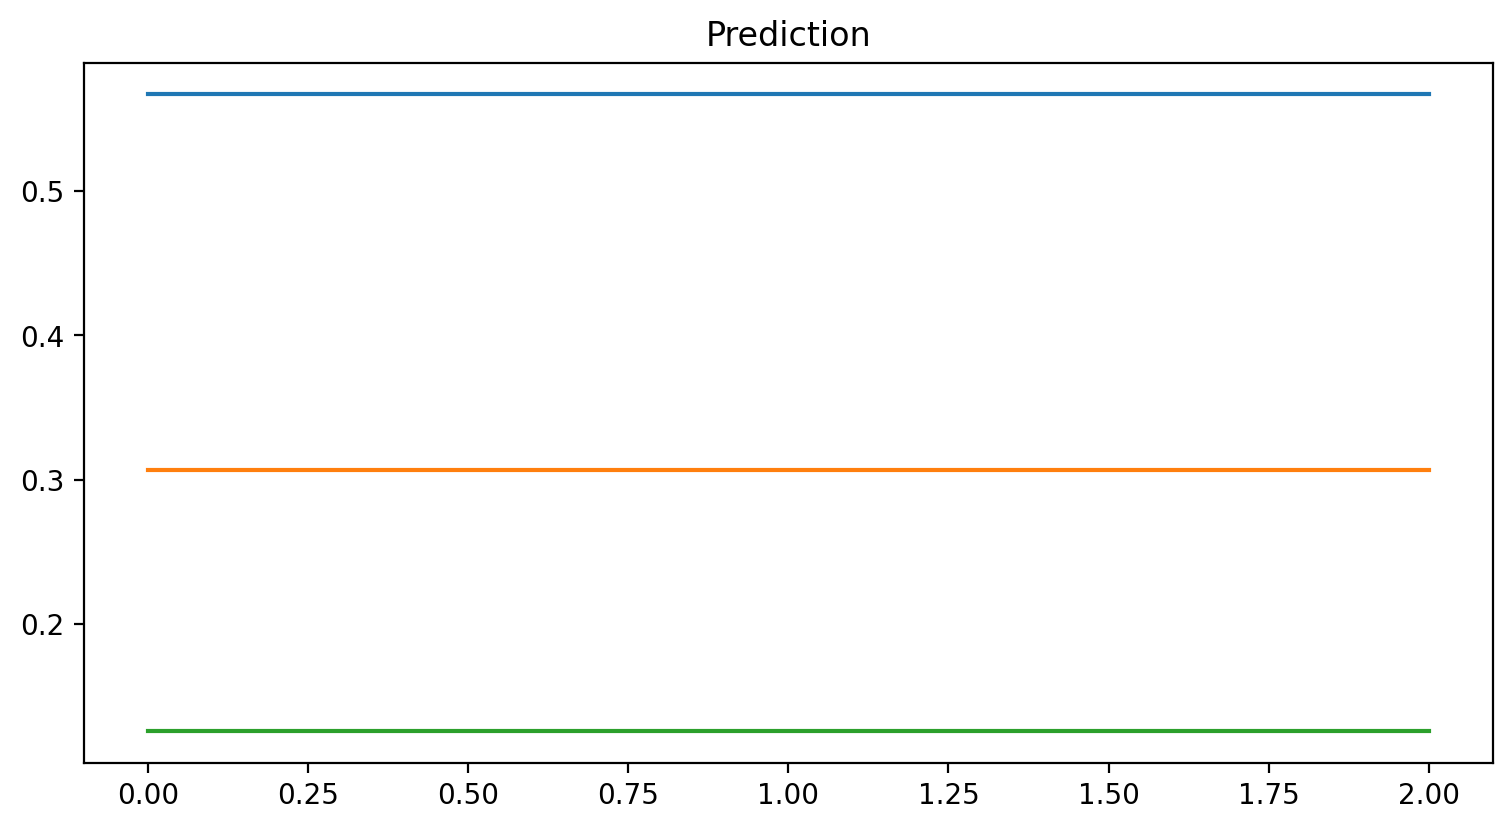

In [ ]:
plt.figure(1,figsize=(20,10))
# plot Classification Metrics: Accuracy
plt.subplot(221, title='Prediction')
plt.plot(y_pred)
plt.show()

In [ ]:
### Loading a Check-Pointed Neural Network Model
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()
# load weights
#model.load_weights('/DataSource/HearbeatHarmonics/best_model_trained1.hdf5')
model.add(Dense(3, activation='softmax'))
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

Build LSTM RNN model ...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 64)            16896     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 29411 (114.89 KB)
Trainable params: 29411 (114.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Created model and loaded weights from file


In [ ]:
from keras.models import load_model

# Load the model
model = load_model('./best_model_trained.hdf5')

x_test = np.random.rand(3, 218903)

x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])


# Make predictions
y_pred = model.predict(x_test)

# Get the class with the highest probability for each sample
y_pred_classes = np.argmax(y_pred, axis=-1)

# Check the scores
scores = model.evaluate(x_test, y_test, verbose=0)
print("Model evaluation accuracy: ", round(scores[1] * 100), "%")

1/1 [==============================] - 1s 800ms/step
Model evaluation accuracy:  100 %
